In [4]:
import os
fold = 0
physiology_path = f"data/scenario_4/fold_{fold}/train/physiology/"
file_list = [physiology_path + f for f in os.listdir(physiology_path)]

physiology_path = f"data/scenario_4/fold_{fold}/test/physiology/"
file_list = file_list+[physiology_path + f for f in os.listdir(physiology_path)]

subs = set([os.path.split(f)[1].split("_")[1] for f in file_list])
vids = set([os.path.split(f)[1].split("_")[3] for f in file_list])

print(len(file_list), len(subs), len(vids))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/scenario_4/fold_0/train/physiology/'

In [8]:
data = pd.read_csv(file_list[0])
data.shape

NameError: name 'file_list' is not defined

In [48]:
import os
print(os.getcwd())



c:\Users\dadam\OneDrive\Escritorio\EPiC-2023-Challenge\notebooks


In [41]:
import os
import pandas as pd 

from pathlib import Path

def load_train_data(sub, video, scenario):
    # create file name based on parameters
    file_name = f"sub_{sub}_vid_{video}.csv"

    # load data files
    train_physiology = pd.read_csv(Path(f"../data/raw/scenario_{scenario}/train/physiology", file_name), index_col="time")
    train_annotations = pd.read_csv(Path(f"../data/raw/scenario_{scenario}/train/annotations", file_name), index_col="time")

    return train_physiology, train_annotations

sub = 1
video = 1
scenario = 1

data, train_annotations = load_train_data(sub, video, scenario)

In [42]:
data.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       103041, 103042, 103043, 103044, 103045, 103046, 103047, 103048, 103049,
       103050],
      dtype='int64', name='time', length=103051)

## Procesamiento para PPG

(10.0, 20.0)

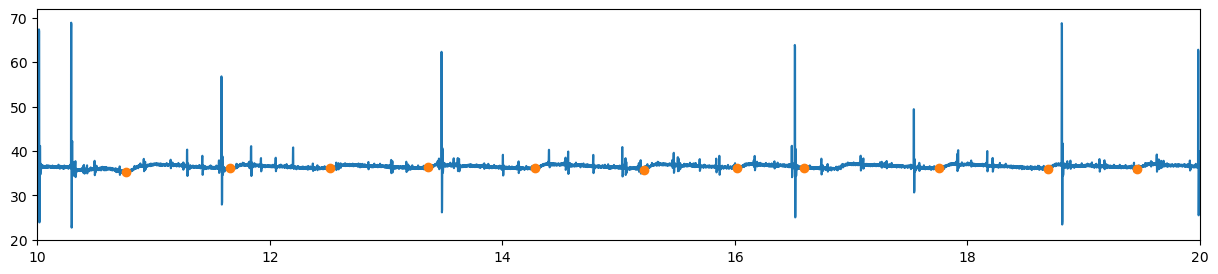

In [49]:
import biosppy
import numpy as np  
from hrvanalysis import remove_outliers
from hrvanalysis import remove_ectopic_beats
from hrvanalysis import interpolate_nan_values
from matplotlib import pyplot as plt

def process_ppg(signal, fs):
    filtered, _, _ = biosppy.tools.filter_signal(signal=signal,
                                                 ftype='butter',
                                                 band='bandpass',
                                                 order=4,
                                                 frequency=[1, 8],
                                                 sampling_rate=fs)

    peaks, _, _ = biosppy.ppg.find_onsets_kavsaoglu2016(signal=filtered,
                                                        sampling_rate=fs)
 
    rr = get_nn(peaks, fs)
    return rr, peaks

def get_nn(peaks, fs):
    """Convert beat peaks in samples to NN intervals and timestamp."""
    rr = np.diff(peaks, prepend=0) * 1000 / fs

    # This remove outliers from signal
    rr = remove_outliers(rr, low_rri=300, high_rri=2000, verbose=False)
    # This replace outliers nan values with linear interpolation
    rr = interpolate_nan_values(rr, interpolation_method="linear")

    # This remove ectopic beats from signal
    # TODO: esto puede no tener sentido en PPG, pero los metodos de features
    #  estan basados en NN y no en RR.
    rr = remove_ectopic_beats(rr, method="malik", verbose=False)
    # This replace ectopic beats nan values with linear interpolation
    rr = np.array(interpolate_nan_values(rr))

    rr[np.where(np.isnan(rr))] = 0
    
    return np.array(rr)


fs = 1000 # todo fisio es 1khz 

rr, peaks = process_ppg(data.bvp, fs)

plt.figure(figsize=(15, 3))
plt.plot(data.index/fs, data.bvp);
plt.plot(peaks/fs, data.bvp[peaks], "o");
plt.xlim([10, 20])

## Procesamiento para ECG


(10.0, 20.0)

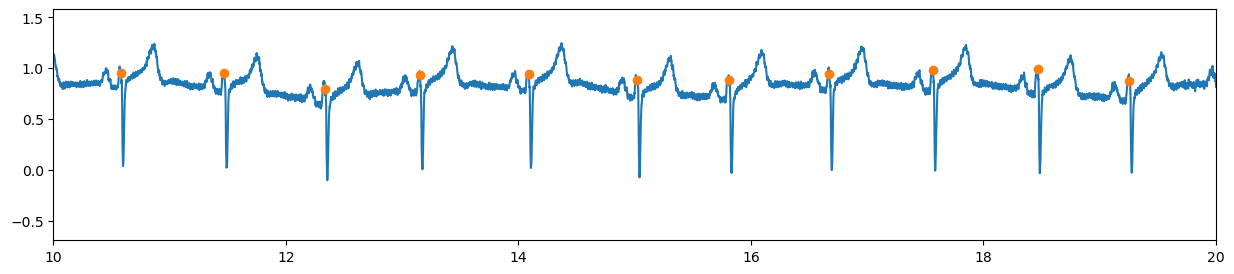

In [50]:
from biosppy.signals import ecg

def process_ecg(signal, fs):
    """Get NN interval from ecg signal."""
    _, _, rpeaks, _, _, _, _ = ecg.ecg(signal,
                                       sampling_rate=fs,
                                       show=False)
    rr = get_nn(rpeaks, fs)

    return rr, rpeaks

rr, peaks = process_ecg(data.ecg, fs)

plt.figure(figsize=(15, 3))
plt.plot(data.index/fs, data.ecg);
plt.plot(peaks/fs, data.ecg[peaks], "o");
plt.xlim([10, 20])

## Features basadas en HR (se pueden sacar del PPG o de ECG)

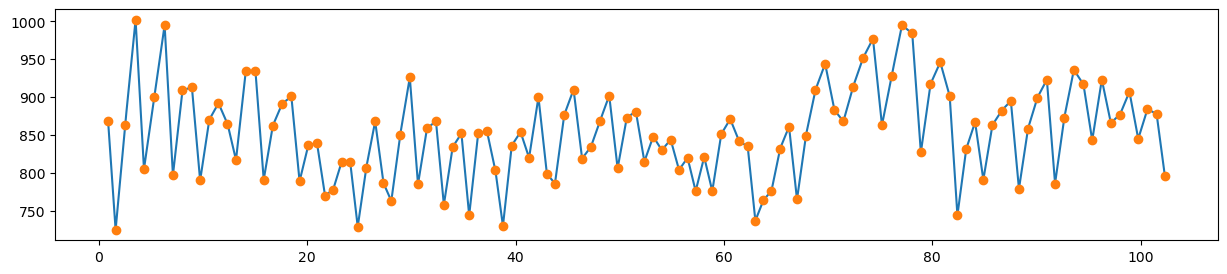

In [51]:
from scipy import interpolate

# Interpolate RR
interpf = interpolate.interp1d(peaks/fs, rr)
timestamp = np.linspace(min(peaks/fs), max(peaks/fs),
                        int((max(peaks/fs) - min(
                            peaks/fs)) * fs))
signal = interpf(timestamp)


plt.figure(figsize=(15, 3))
plt.plot(timestamp, signal);
plt.plot(peaks/fs, rr, "o");


In [55]:
signal = pd.DataFrame({"rr_cleaned": signal}, index=timestamp)
#signal_2 = signal.reindex(data.index, method='nearest')
    
plt.figure(figsize=(15, 3))
plt.plot(data.index, signal[:0]);
plt.plot(peaks/fs, rr, "o");


ValueError: Data must be 1-dimensional, got ndarray of shape (101460, 1) instead

In [46]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_csi_cvi_features
from hrvanalysis import get_poincare_plot_features

def hrv_features(rr):
    """Calcula diferentes feautres de HRV. Muchas requieren ventanas temporales grandes (1-5min)"""
    feats = {}

    feats.update(get_time_domain_features(rr))
    feats.update(get_geometrical_features(rr))
    feats.update(get_frequency_domain_features(rr))
    feats.update(get_csi_cvi_features(rr))
    feats.update(get_poincare_plot_features(rr))

    return feats

feat = hrv_features(rr)
len(feat)

31

In [47]:
feat['mean_nni']

851.5791666666667

## TODO
- Normalizar y filtrar nans
- sacar features de amplitud de PPG 
- Ver si hay diferencias importantes en feautres de HRV sino usar solo ECG
- Algunas features estan pensadas para ventanas temporales mas grandes, se podría evaluar igual en
  ventanas de 10-20 s, y si no son discriminativas se puede calcular en ventanas mas grandes y
  muestrear con las ventanas mas chicas

Estas features en un baseline sencillo (ventaneo de la señal para sacar features en el tiempo,
robusscaler y linear discriminant analysis anduvo en un caso de detección de estres)